# Permutation-based global & local selection in the melanoma data (293 spots, ST platform)

In [1]:
import os
import pandas as pd
import numpy as np
import anndata as ann

import spatialdm as sdm
from spatialdm.datasets import dataset
import spatialdm.plottings as pl
print("SpatailDM version: %s" %sdm.__version__)

SpatailDM version: 0.0.2


The melanoma dataset from Thrane, et al. was publicly available, and we obtained raw counts, pre-processed log counts, and spatial coordinates from Matt Stone ([Git repository](https://github.com/msto/spatial-datasets)). For easier reuse, we included them in an anndata object which can be loaded directly in SpatialDM Python package.

In [2]:
adata = dataset.melanoma()

/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


The anndata object contains the following:\
    log-transformed expression in `adata.X`, \
    raw expression in `adata.raw`,\
    cell types computed by RCTD in `adata.obs`,\
    and spatial coordinates in `adata.obsm['spatial']`

In [3]:
raw = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.var_names)
log = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
raw.head()

PSME2  CUEDC1  RPLP1  TM9SF3  DEF8  RPL37A  NELL1  MFGE8  AIP  TSC22D3  \
1      2       0     21       0     0      28      2      2    1        0   
2      0       0     13       0     0      13      0      3    0        0   
3      0       0     13       0     0      15      0      2    0        0   
4      0       1     18       0     1      17      2      3    1        0   
5      0       0     10       0     0       3      0      2    0        0   

   ...  TREM1  C2CD4A  TAF1L  PEBP4  BCL2L15  MYBPC2  RHOD  PPEF1  CKMT2  \
1  ...      0       0      0      0        0       0     0      0      0   
2  ...      0       0      0      0        0       0     0      0      0   
3  ...      0       0      0      0        0       0     0      0      0   
4  ...      0       0      0      0        0       0     0      0      0   
5  ...      0       0      0      0        0       0     0      0      0   

   PGM5P2  
1       0  
2       0  
3       0  
4       0  
5       0  

[5 rows x 16148 columns]

In [4]:
log.head()

PSME2    CUEDC1     RPLP1  TM9SF3      DEF8    RPL37A     NELL1  \
1  1.813059  0.000000  4.775871     0.0  0.000000  5.177683  1.813059   
2  0.000000  0.000000  5.436410     0.0  0.000000  5.436410  0.000000   
3  0.000000  0.000000  5.330760     0.0  0.000000  5.532423  0.000000   
4  0.000000  1.755626  5.452236     0.0  1.755626  5.371711  2.524428   
5  0.000000  0.000000  5.327188     0.0  0.000000  3.671727  0.000000   

      MFGE8       AIP  TSC22D3  ...  TREM1  C2CD4A  TAF1L  PEBP4  BCL2L15  \
1  1.813059  1.174363      0.0  ...    0.0     0.0    0.0    0.0      0.0   
2  3.427919  0.000000      0.0  ...    0.0     0.0    0.0    0.0      0.0   
3  2.815122  0.000000      0.0  ...    0.0     0.0    0.0    0.0      0.0   
4  3.023288  1.755626      0.0  ...    0.0     0.0    0.0    0.0      0.0   
5  3.142286  0.000000      0.0  ...    0.0     0.0    0.0    0.0      0.0   

   MYBPC2  RHOD  PPEF1  CKMT2  PGM5P2  
1     0.0   0.0    0.0    0.0     0.0  
2     0.0   0.0    0.0    0.0     0.0  
3     0.0   0.0    0.0    0.0     0.0  
4     0.0   0.0    0.0    0.0     0.0  
5     0.0   0.0    0.0    0.0     0.0  

[5 rows x 16148 columns]

In [5]:
spatialcoord = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])
spatialcoord.head()

x  y
1  15  7
2  16  7
3  17  7
4  18  7
5  13  8

The logcounts, rawcounts, and spatial coordinates are mandatory DataFrame input for SpatialDM, which should have **the exact same 
index**. \
Spatial coordinates can be multi-dimentional, while illustrated a 2-D example here.

<div class="alert alert-info">

**Note**
SpatialDM supports loading data directly from csv files
</div>

In [6]:
# # alternatively load via pandas
# datadir = '/home/yoyo/1_spatial/1_Tumor/data/'
# spatialcoord = pd.read_csv(datadir+'spatialcoord.csv', index_col=0)
# spatialcoord.columns = ['x', 'y']
# spatialcoord.head()

# log=pd.read_csv(datadir + 'logcounts.csv',header=0,index_col=0)
# log = log.transpose()
# log.index = spatialcoord.index
# log.head()

# raw=pd.read_csv(datadir + 'rawcounts.csv',header=0,index_col=0)
# raw = raw.transpose()
# raw.index = spatialcoord.index
# raw.head()

## SpatialDM object and preprocessing

We generate a suitable weight matrix for the SpatialDM object at first. Here considering the scale of the spatial coordinates and spot-spot distance (200 micrometers here), we set radial basis kernel parameter l = 1.2, and trimmed all weights < 0.2 (cutoff) to match the normal range of CCC (200 micrometers, 1 spot away from the sender cell here)

<div class="alert alert-info">

**Note**
Alternative to the cutoff parameter, we can set n_neighbors to around 8 to restrain the range of CCC.

</div>

In [7]:
my_sample = sdm.SpatialDM(log, raw, spatialcoord)     # load spatial data
my_sample.weight_matrix(l=1.2, cutoff=0.2, single_cell=False) # weight_matrix by rbf kernel

<div class="alert alert-info">

**Note**
    
If the scale of the spatial coordinates is larger (e.g. several thousand in the intestinal example) or smaller, or when the spot-spot distance varies (which is common for different platforms), the `l` can be very different. It's a crucial step to determine a suitable `l` to match the biological context. We recommend the following plotting to check the resulting weight matrix from the previous step. If needed, users can run ```weight_matrix``` iteratively to decide the most optimal `l` and `cutoff`.
</div>

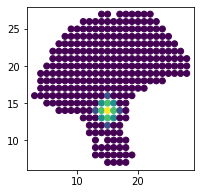

In [8]:
# visualize range of interaction
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.scatter(my_sample.spatialcoord.x, my_sample.spatialcoord.y, c=my_sample.rbf_d[50])

Next step is to extract valid LR pairs from the database (by default, we use CellChatDB). Filtering out sparsely expressed ligand or receptor (e.g. 3) can help us get more interpretable results later.

In [9]:
my_sample.extract_lr('human', min_cell=3)      # find overlapping LRs from CellChatDB

## Global and local selection (permutation approach)

It is a crucial step to identify dataset-specific interacting LR pairs (global selection) for ensuring quality analysis and reliable interpretation of the putative CCC. With high computation efficiency, SpatialDM can complete global selection in seconds. 

In [10]:
import time
start = time.time()
my_sample.spatialdm_global(1000, select_num=None, method='both', nproc=1)     # global Moran selection
my_sample.sig_pairs(method='permutation', fdr=True, threshold=0.1)     # select significant pairs
print("%.3f seconds" %(time.time()-start))

100%|██████████| 1000/1000 [00:01<00:00, 523.72it/s]

2.142 seconds


We used fdr corrected global p-values and a threshold FDR < 0.1 (default) to determine which pairs to be included in the following local identification steps. There are 133 pairs being selected in this data.

Local selection is then carried out for the selected 133 pairs to identify where the LRI take place, in a single-spot resolution.

In [11]:
start = time.time()
my_sample.spatialdm_local(n_perm=1000, method='both', select_num=None, nproc=1)     # local spot selection
my_sample.sig_spots(method='permutation', fdr=False, threshold=0.1)     # significant local spots
print("%.3f seconds" %(time.time()-start))

100%|██████████| 1000/1000 [00:00<00:00, 1816.91it/s]


0.713 seconds


By default, local selection is performed for all selected pairs in the previous step. 

<div class="alert alert-info">

**Note**    
Apply an array of integer indices of selected pairs to `select_num` to run local selection in selected pairs
</div>

The global and local results are easily accessible through ```global_res``` and ```local_perm_p``` or ```local_z_p```

In [12]:
my_sample.global_res.sort_values(by='fdr')

ligand        receptor        z_pval  perm_pval  fdr  \
ITGA4_ITGB7_VCAM1    [ITGA4]         [VCAM1]  1.373509e-09      0.000  0.0   
FCER2A_ITGAM_ITGB2   [FCER2]  [ITGAM, ITGB2]  4.376185e-18      0.000  0.0   
FCER2A_ITGAX_ITGB2   [FCER2]  [ITGAX, ITGB2]  1.270430e-16      0.000  0.0   
FCER2A_CR2           [FCER2]           [CR2]  2.949582e-14      0.000  0.0   
PTPRC_CD22           [PTPRC]          [CD22]  8.053935e-56      0.000  0.0   
...                      ...             ...           ...        ...  ...   
LAMC1_ITGA6_ITGB1    [LAMC1]  [ITGA6, ITGB1]  9.845550e-01      1.000  1.0   
LAMC2_ITGA6_ITGB1    [LAMC2]  [ITGA6, ITGB1]  6.531066e-01      0.641  1.0   
LAMA3_ITGA7_ITGB1    [LAMA3]  [ITGA7, ITGB1]  7.267100e-01      0.739  1.0   
COL9A2_ITGA3_ITGB1  [COL9A2]  [ITGA3, ITGB1]  9.969283e-01      0.996  1.0   
THBS2_ITGA3_ITGB1    [THBS2]  [ITGA3, ITGB1]  9.993004e-01      0.998  1.0   

                    selected  
ITGA4_ITGB7_VCAM1       True  
FCER2A_ITGAM_ITGB2      True  
FCER2A_ITGAX_ITGB2      True  
FCER2A_CR2              True  
PTPRC_CD22              True  
...                      ...  
LAMC1_ITGA6_ITGB1      False  
LAMC2_ITGA6_ITGB1      False  
LAMA3_ITGA7_ITGB1      False  
COL9A2_ITGA3_ITGB1     False  
THBS2_ITGA3_ITGB1      False  

[946 rows x 6 columns]

## Visualize pair(s)

SpatialDM provides plotting utilities for general summary of global results:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

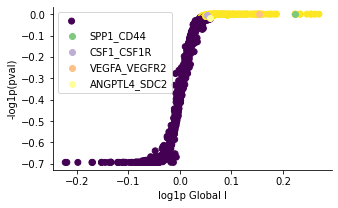

In [13]:
pl.global_plot(my_sample, pairs=['SPP1_CD44', 'CSF1_CSF1R', 'VEGFA_VEGFR2', 'ANGPTL4_SDC2'], figsize=(5,3))

Known melanoma-related pairs were all observed in the selected pairs. It would then be meaningful to investigate the spatial context of their interactions.

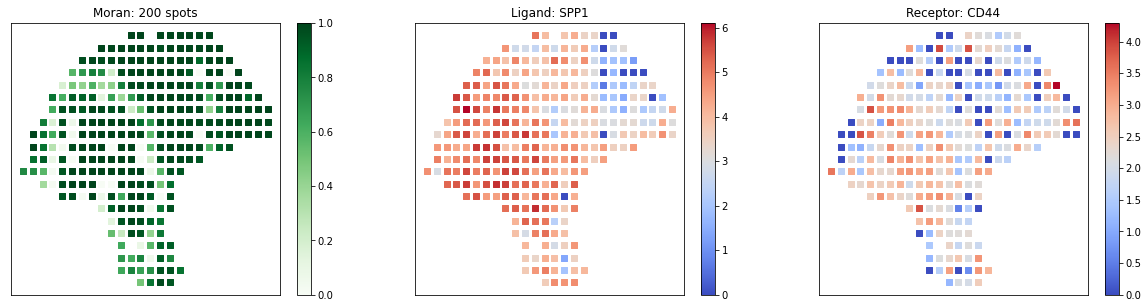

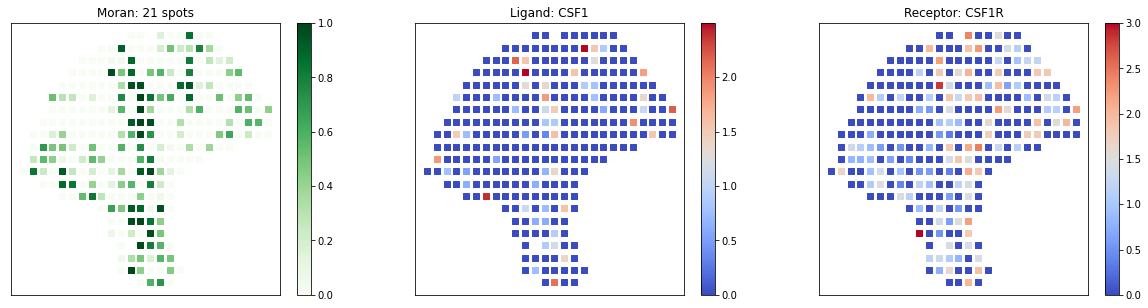

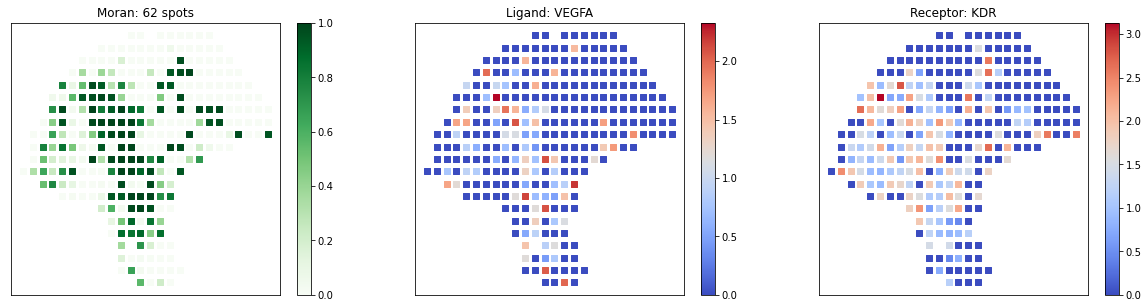

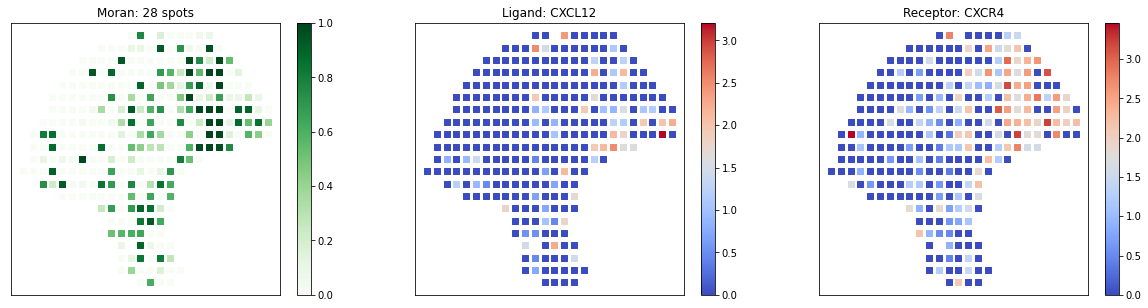

In [14]:
# visualize known melanoma pairs
pl.plot_pairs(my_sample, ['SPP1_CD44', 'CSF1_CSF1R', 'VEGFA_VEGFR2', 'CXCL12_CXCR4'], marker='s')

Save the global and local results to a new directory, which allows easy reload later.

In [15]:
data_dir='output/'
my_sample.save_spataildm(data_dir, exclude = ['local_permI','local_permI_R'])
# my_sample = read_spataildm(data_dir)

## Spatial Clustering of Local Spots

[SpatialDE](https://github.com/Teichlab/SpatialDE) allows clustering of spatially auto-correlated genes. Here, we repurposed SpatialDE to identify spatially auto-correlated interactions by using binary local selection status as input.

In [16]:
import NaiveDE
import SpatialDE

Filter out sparse interactions with fewer than 3 identified interacting spots.
Cluster into 6 patterns.

In [17]:
# SpatialDE code
bin_spots = my_sample.selected_spots.astype(int)[my_sample.n_spots>2]
print(bin_spots.shape[0], " pairs used for spatial clustering")

130  pairs used for spatial clustering


In [18]:
results = SpatialDE.run(my_sample.spatialcoord, bin_spots.transpose())

histology_results, patterns = SpatialDE.aeh.spatial_patterns(my_sample.spatialcoord, bin_spots.transpose(),
                                                             results, C=6, l=3,
                                                             verbosity=1)

/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

iter 0, ELBO: -6.72e+10
iter 1, ELBO: -3.13e+10, delta_ELBO: 3.59e+10
iter 2, ELBO: -3.13e+10, delta_ELBO: 5.26e+03
iter 3, ELBO: -3.13e+10, delta_ELBO: 8.73e+02
iter 4, ELBO: -3.13e+10, delta_ELBO: 4.49e+02
iter 5, ELBO: -3.13e+10, delta_ELBO: 6.39e+01
iter 6, ELBO: -3.13e+10, delta_ELBO: 1.04e+02
iter 7, ELBO: -3.13e+10, delta_ELBO: 6.26e+01
iter 8, ELBO: -3.13e+10, delta_ELBO: 2.74e+01
iter 9, ELBO: -3.13e+10, delta_ELBO: 1.01e+01
iter 10, ELBO: -3.13e+10, delta_ELBO: 1.29e+01
iter 11, ELBO: -3.13e+10, delta_ELBO: 2.43e+00
iter 12, ELBO: -3.13e+10, delta_ELBO: 1.50e+00
iter 13, ELBO: -3.13e+10, delta_ELBO: 5.04e+00
iter 14, ELBO: -3.13e+10, delta_ELBO: 5.31e+00
iter 15, ELBO: -3.13e+10, delta_ELBO: 9.02e-02
iter 16, ELBO: -3.13e+10, delta_ELBO: 6.07e-02
iter 17, ELBO: -3.13e+10, delta_ELBO: 5.36e-02
iter 18, ELBO: -3.13e+10, delta_ELBO: 5.45e-02
iter 19, ELBO: -3.13e+10, delta_ELBO: 5.44e-02
iter 20, ELBO: -3.13e+10, delta_ELBO: 5.43e-02
iter 21, ELBO: -3.13e+10, delta_ELBO: 4.04e-0

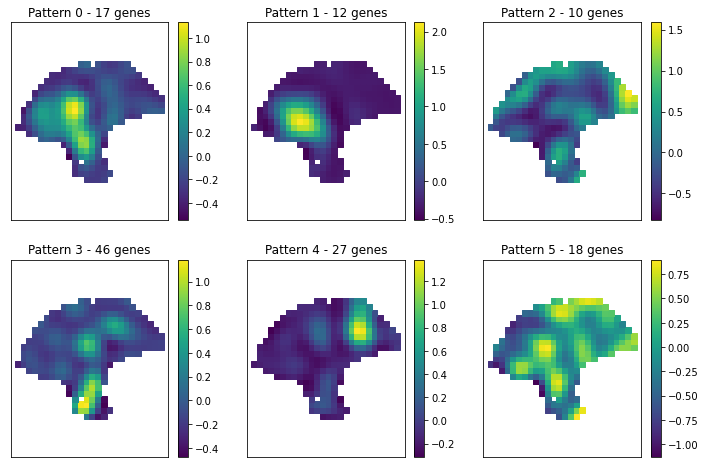

In [19]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.scatter(my_sample.spatialcoord['x'], my_sample.spatialcoord['y'], marker = 's',c=patterns[i], s=35);
    plt.axis('equal')
    pl.plt_util('Pattern {} - {} genes'.format(i, histology_results.query('pattern == @i').shape[0] ))

<div class="alert alert-info">

**Note**
    For detail parameter settings like `C` and `l`, please refer to SpatialDE [tutorial](https://github.com/Teichlab/SpatialDE)
</div>

SpatialDM provides `compute_pathway` function to group a list of interactions based on the pathways they belong. THe input can be a dictionary of several lists.

In [20]:
dic=dict()
for i in histology_results.sort_values('pattern').pattern.unique():
    dic['Pattern_{}'.format(i)]=histology_results.query('pattern == @i').sort_values('membership')['g'].values

In [21]:
sdm.compute_pathway(my_sample, dic=dic)

In the dot plot of the lymphoid-associated pattern, we identified CD23 and other immune-related pathways.

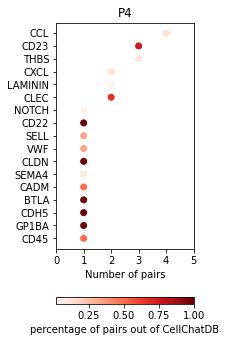

In [22]:
pl.dot_path(my_sample, 'P4')

Use `plot_pairs` to visualize all pairs in pattern 4

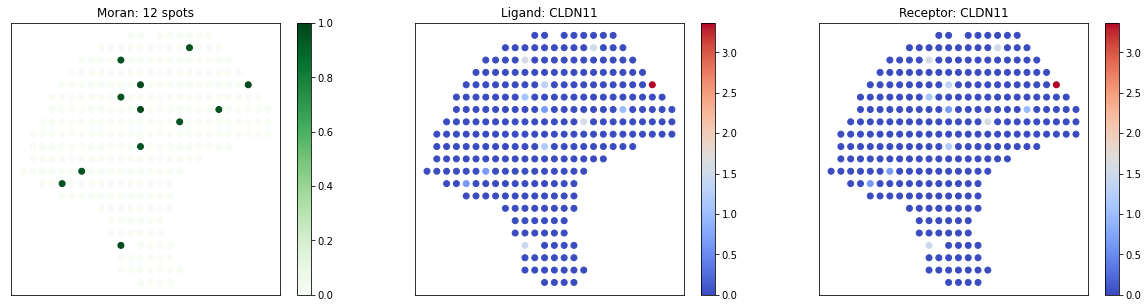

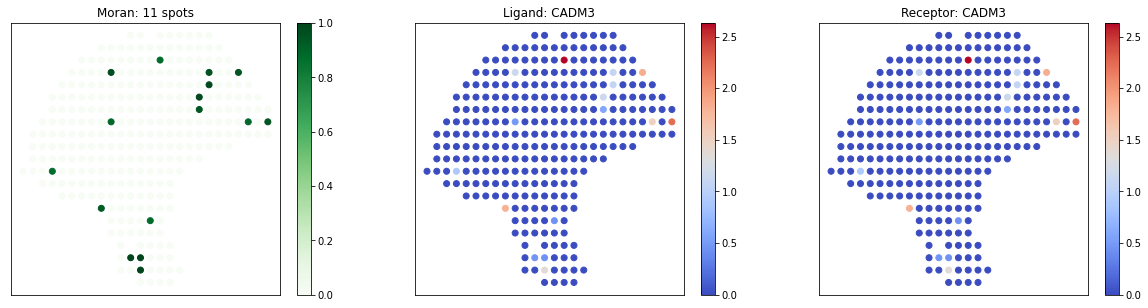

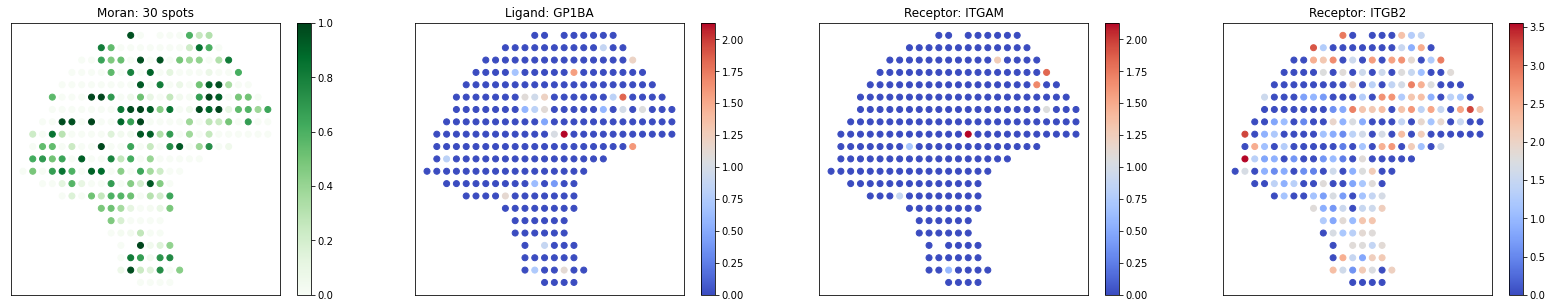

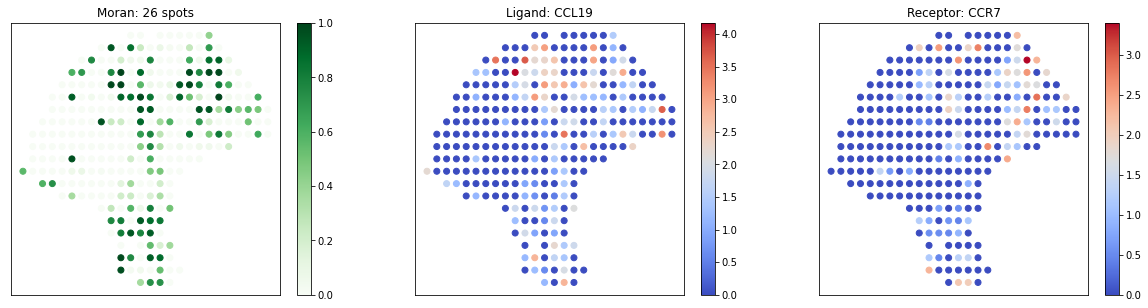

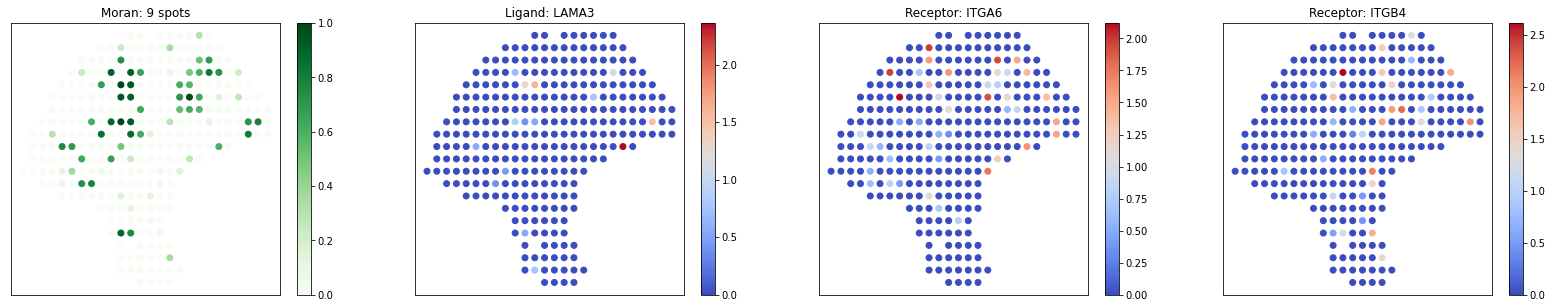

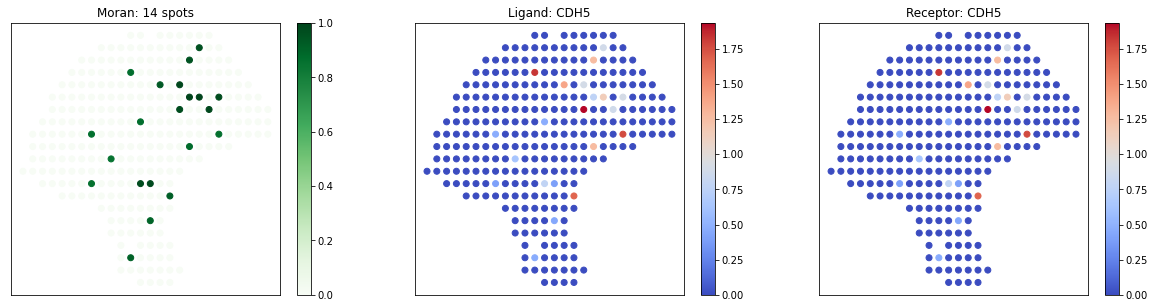

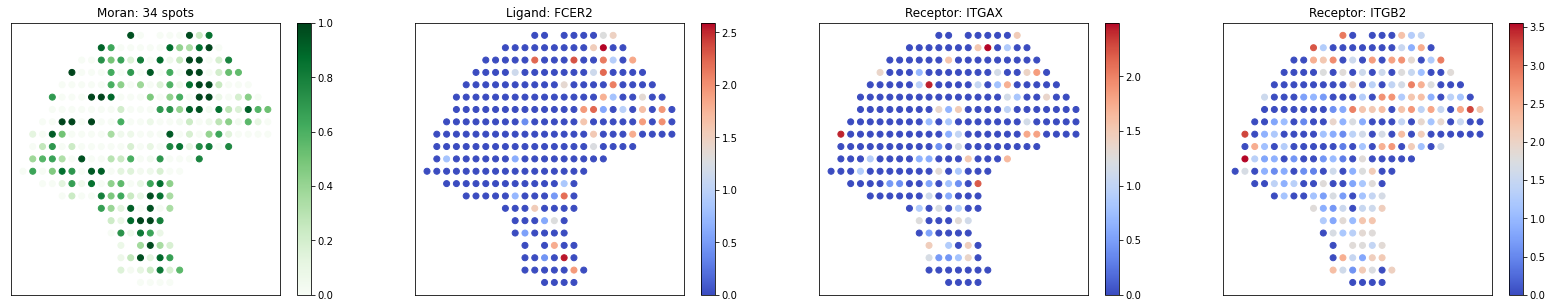

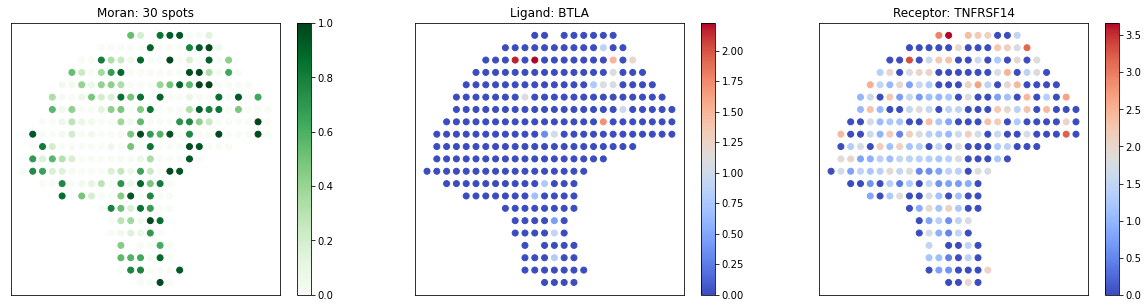

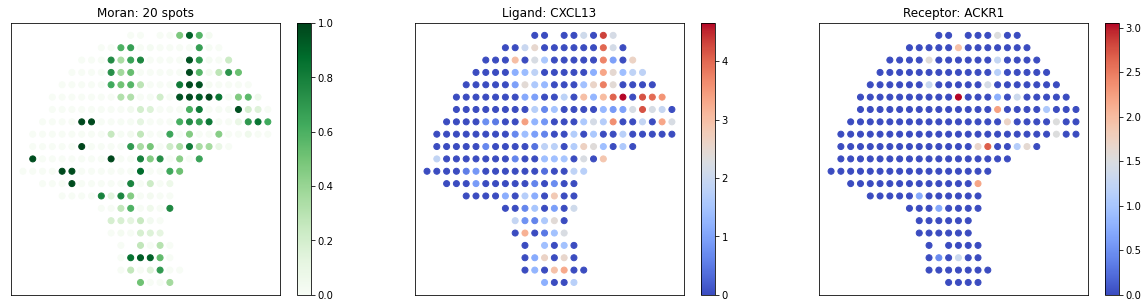

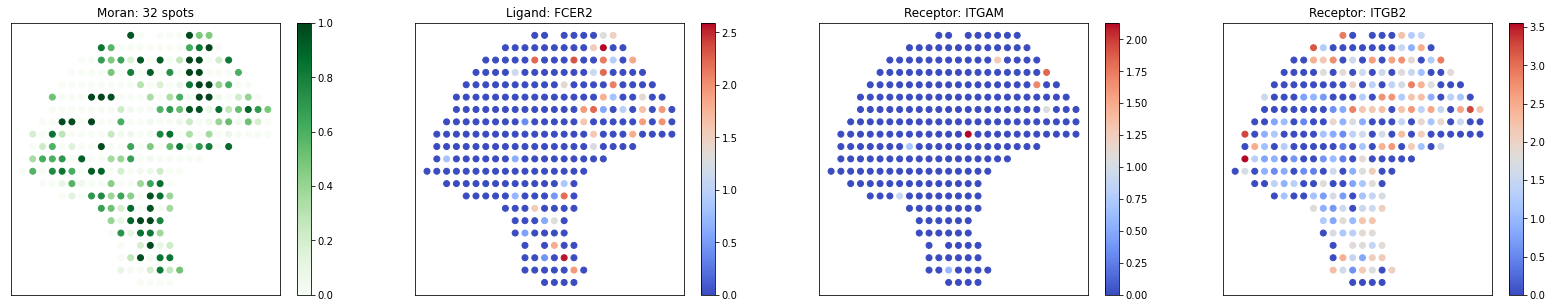

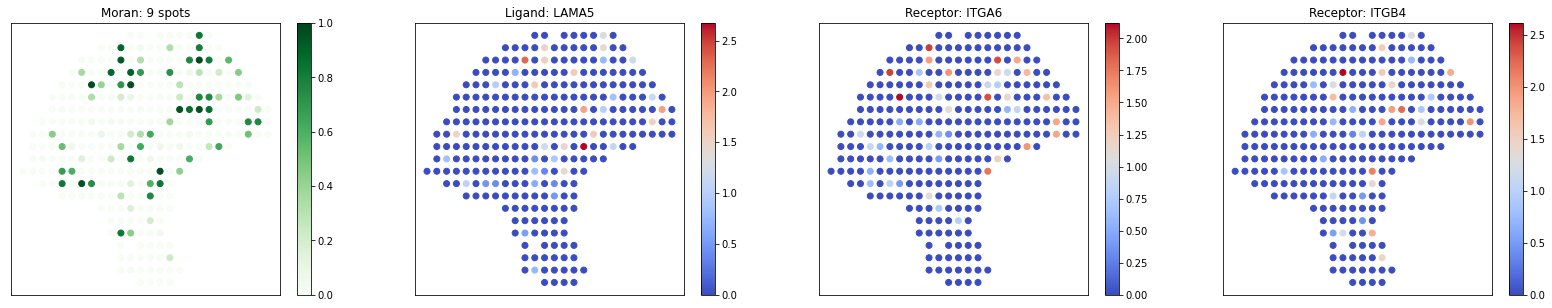

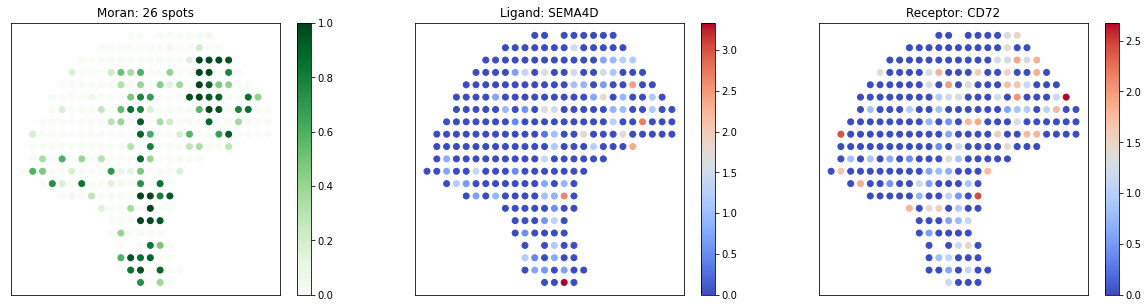

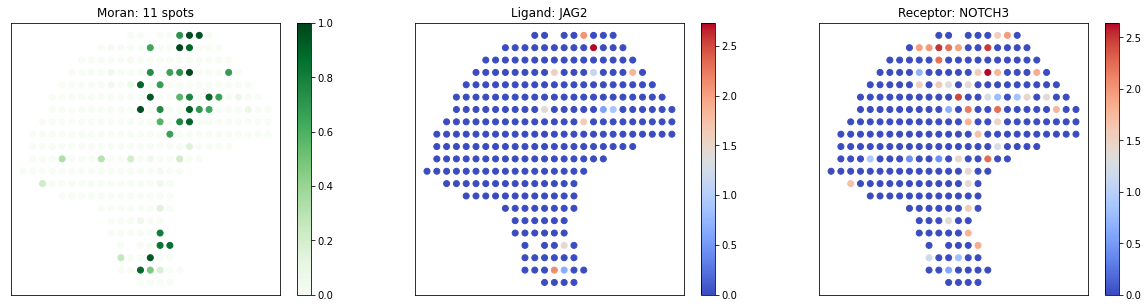

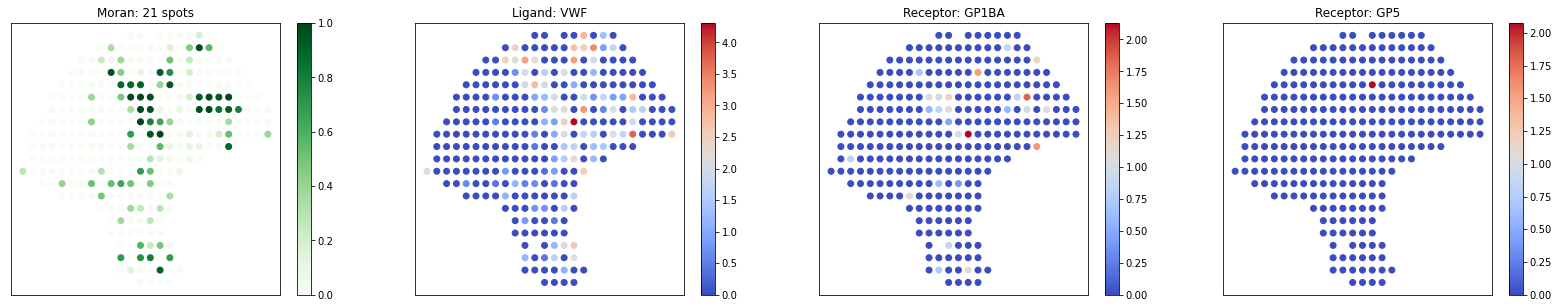

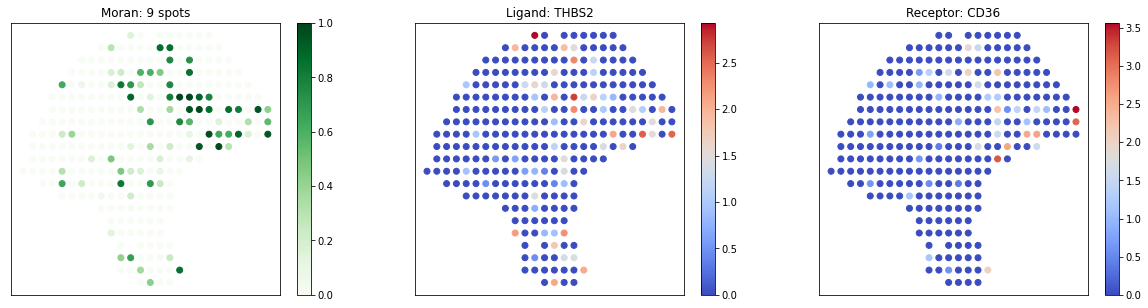

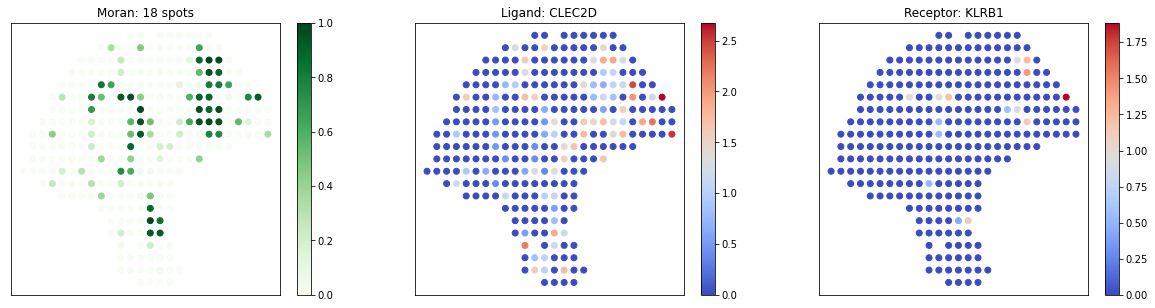

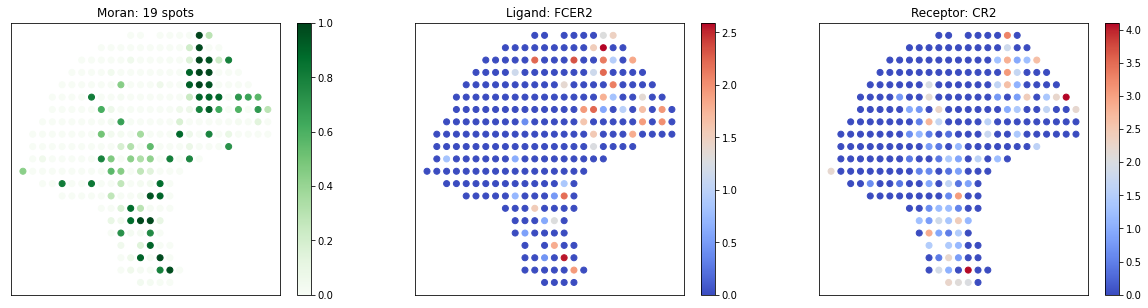

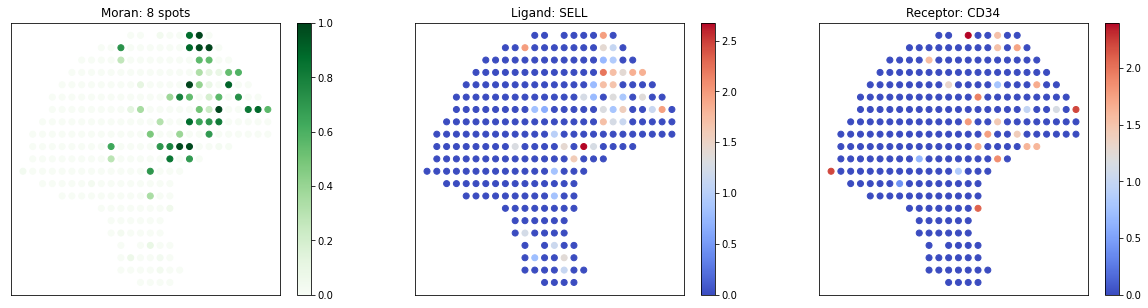

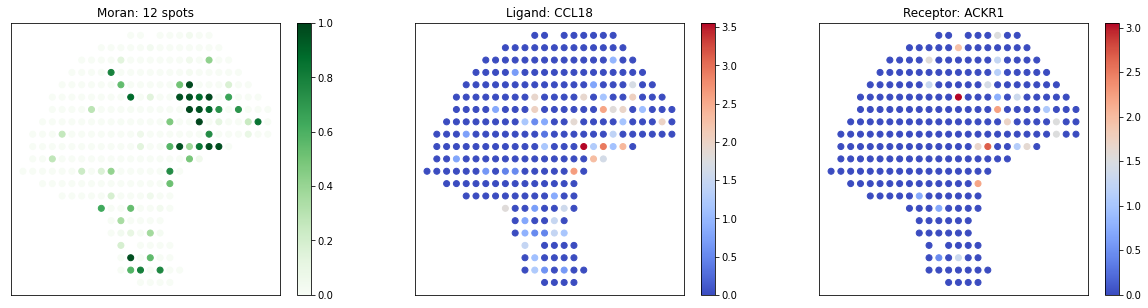

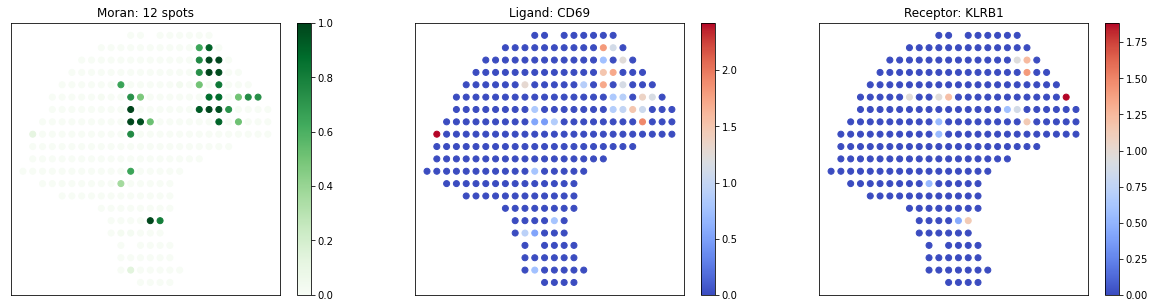

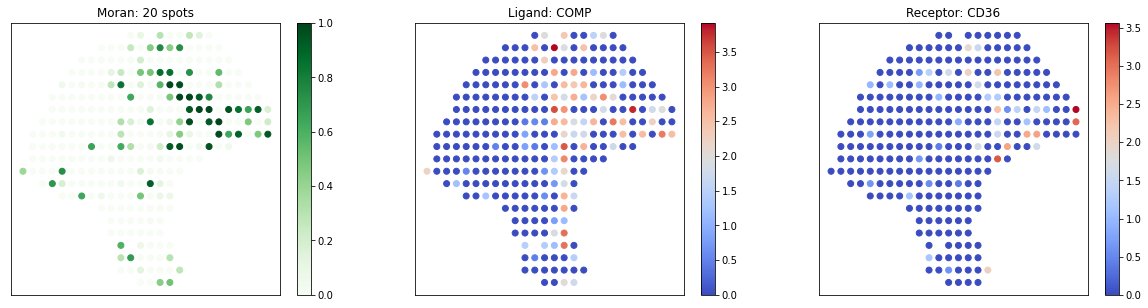

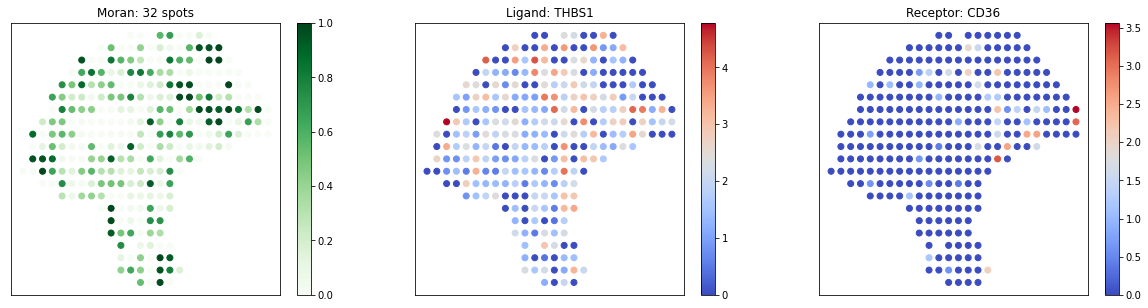

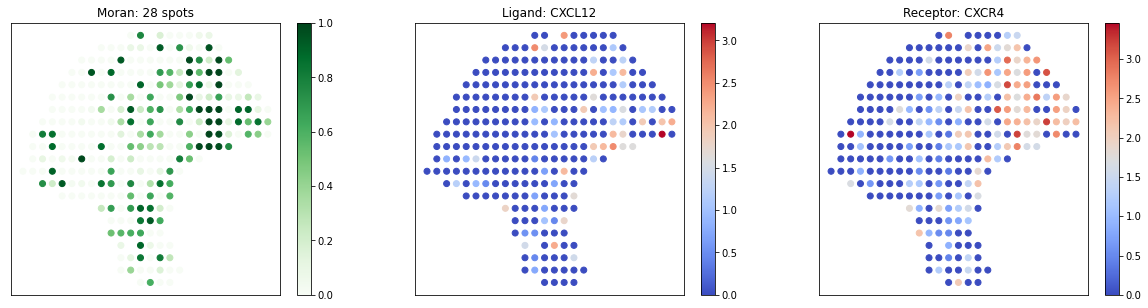

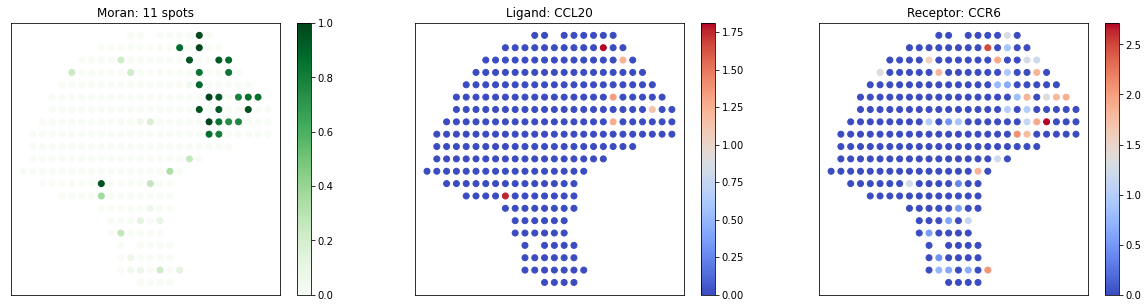

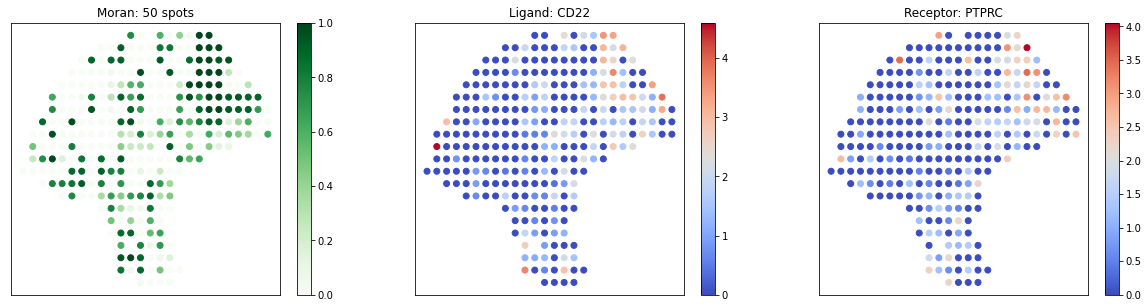

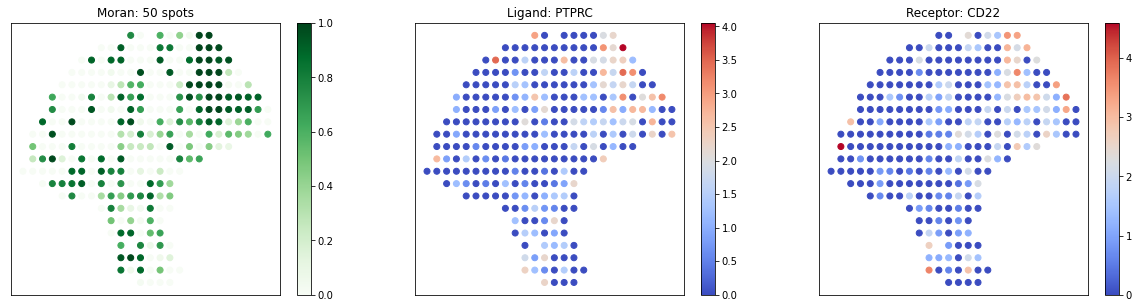

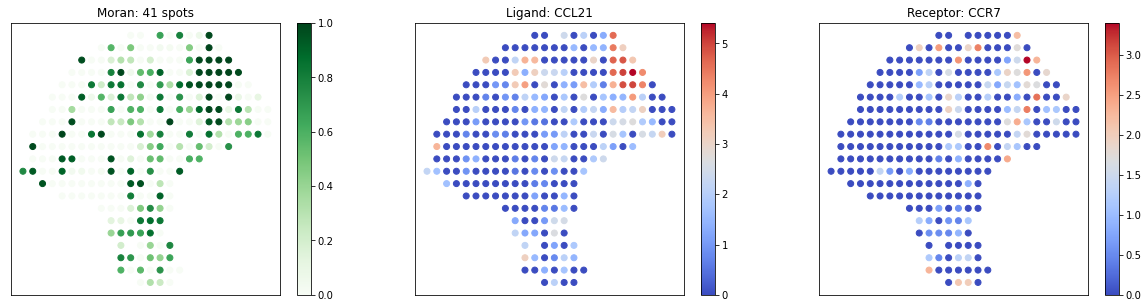

In [23]:
# visualize pattern 2 pairs
pl.plot_pairs(my_sample, dic['Pattern_4'])

Pattern 0 recaptures "tumor boundary region" and the enriched pathways could reveal tumor-immune interplay.

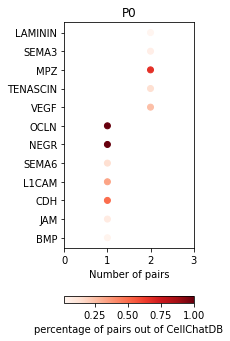

In [24]:
pl.dot_path(my_sample, 'P0')

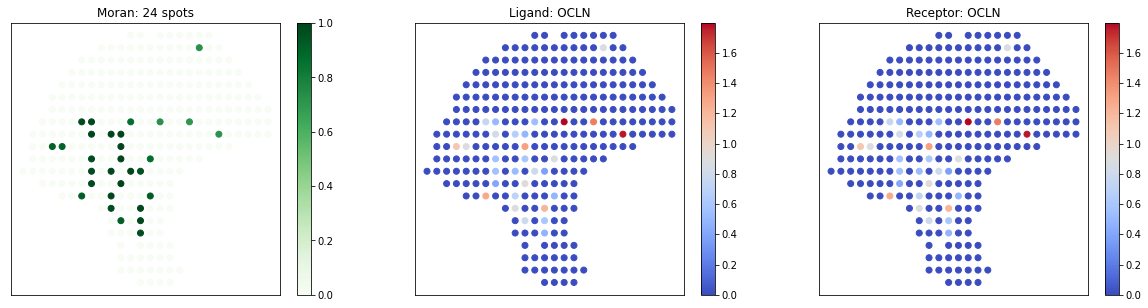

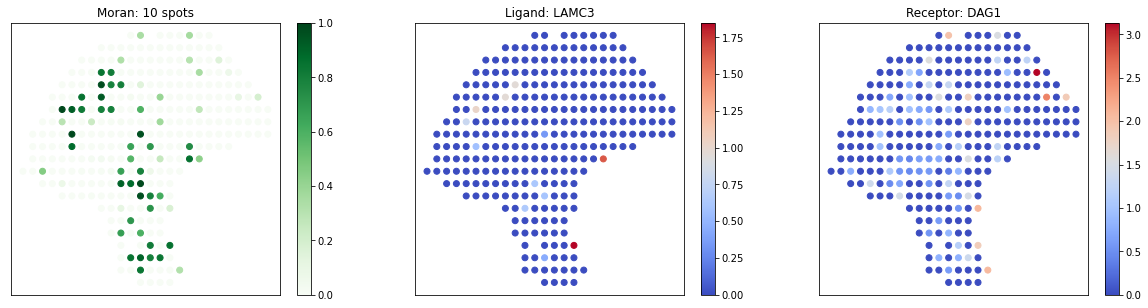

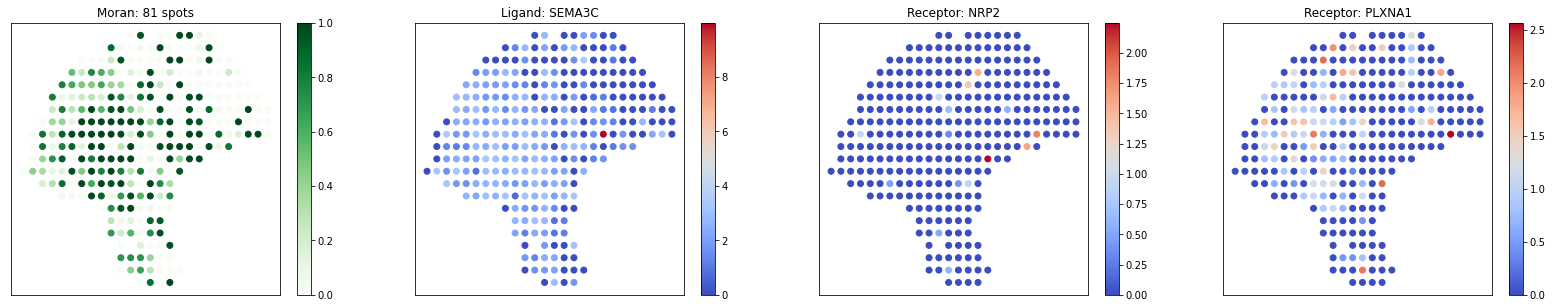

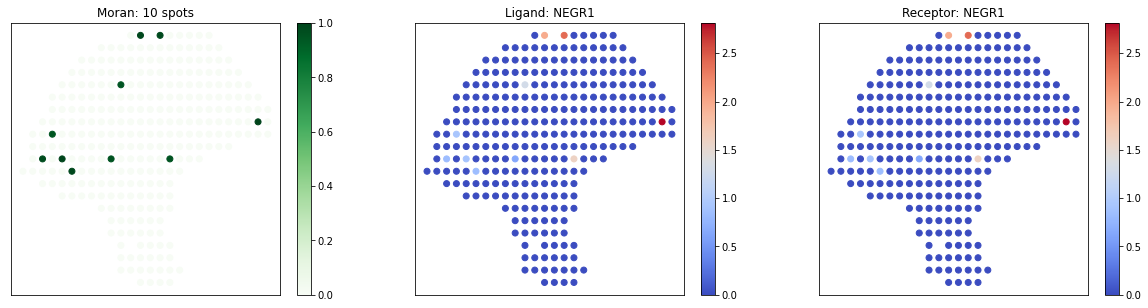

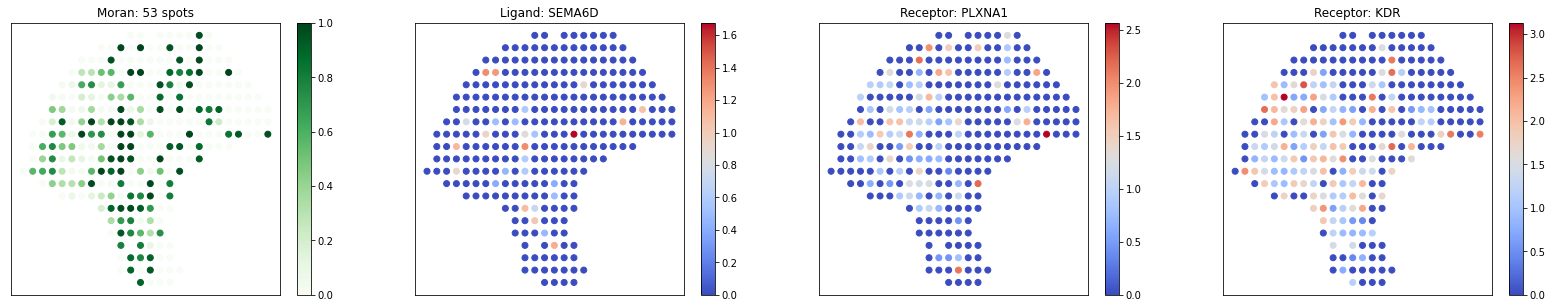

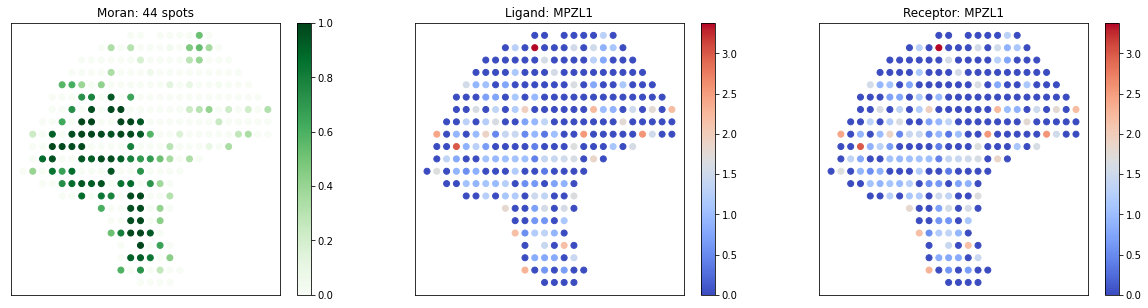

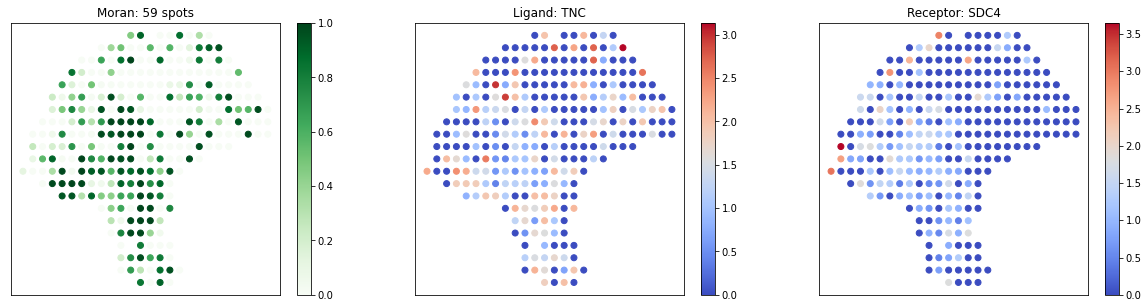

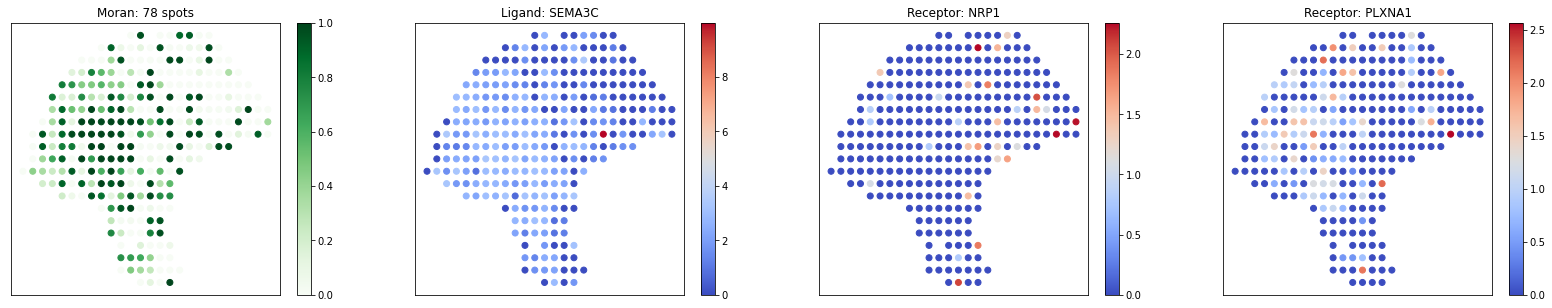

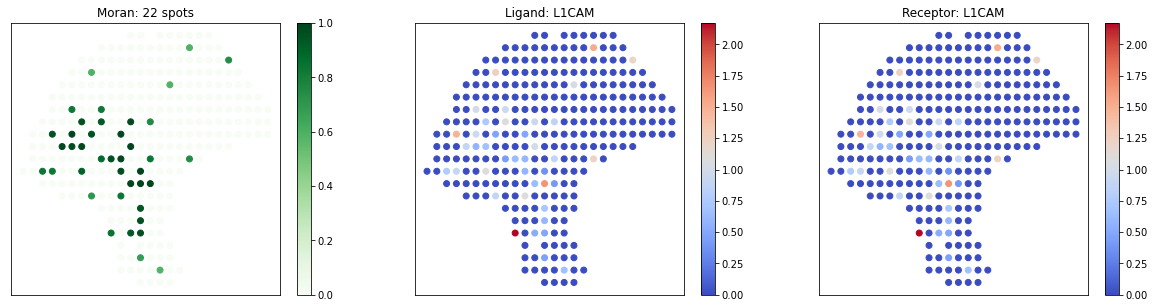

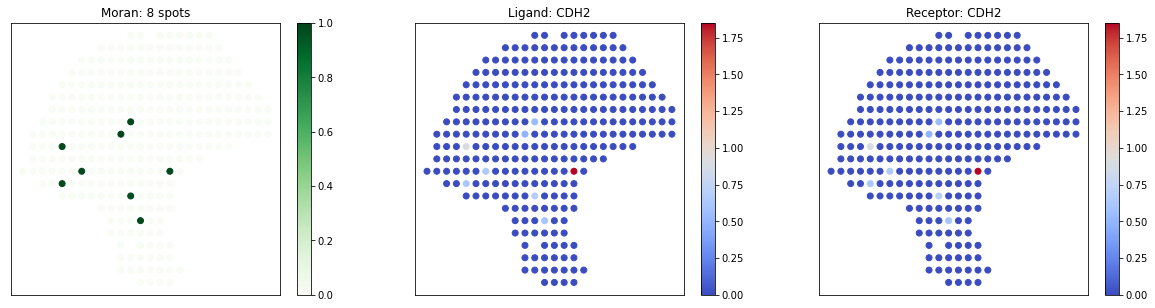

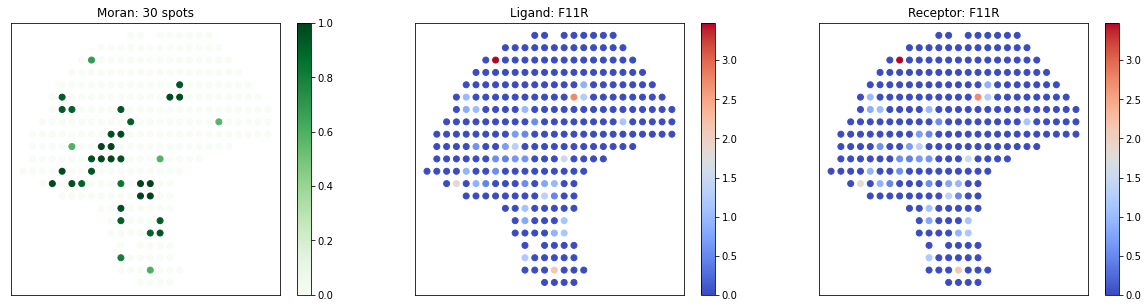

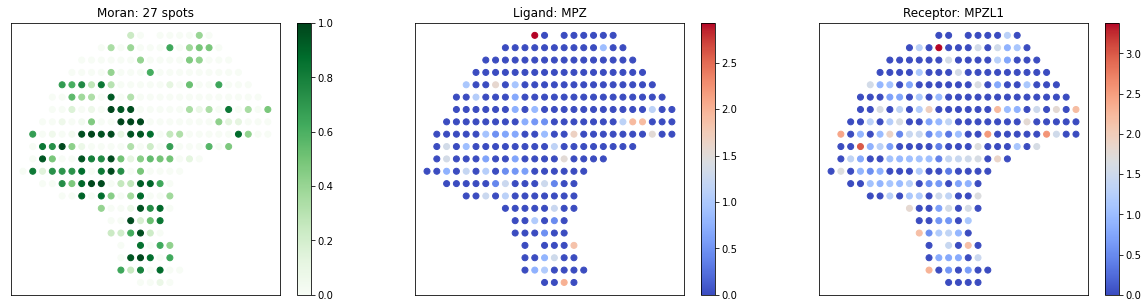

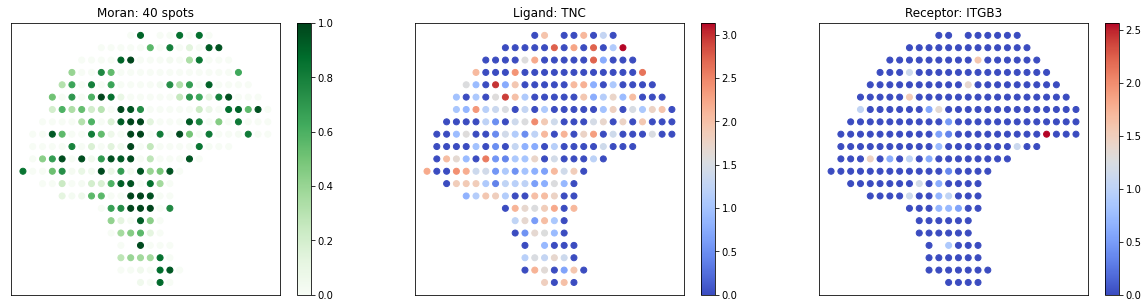

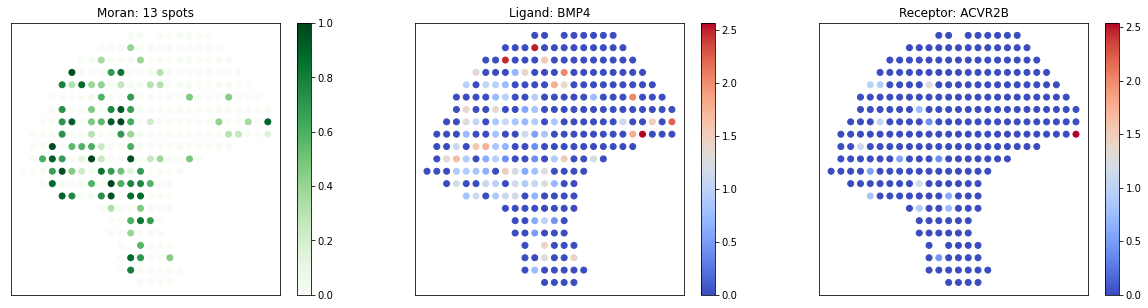

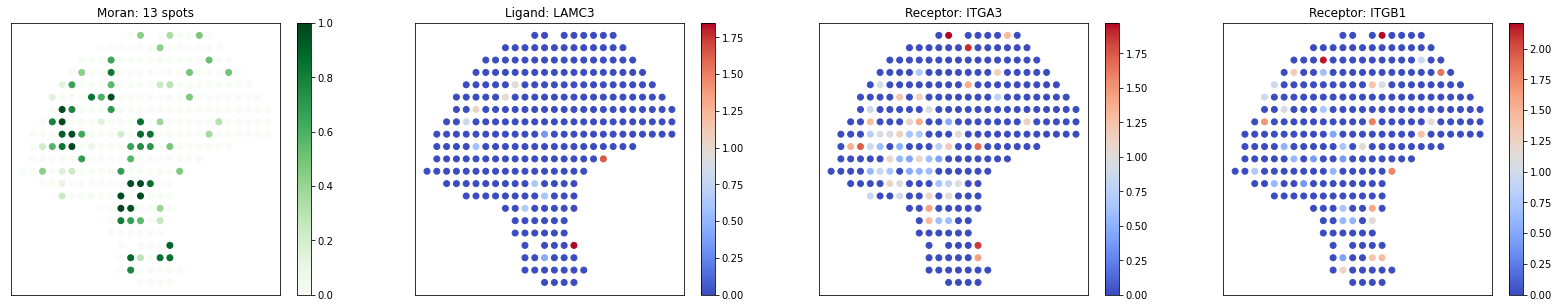

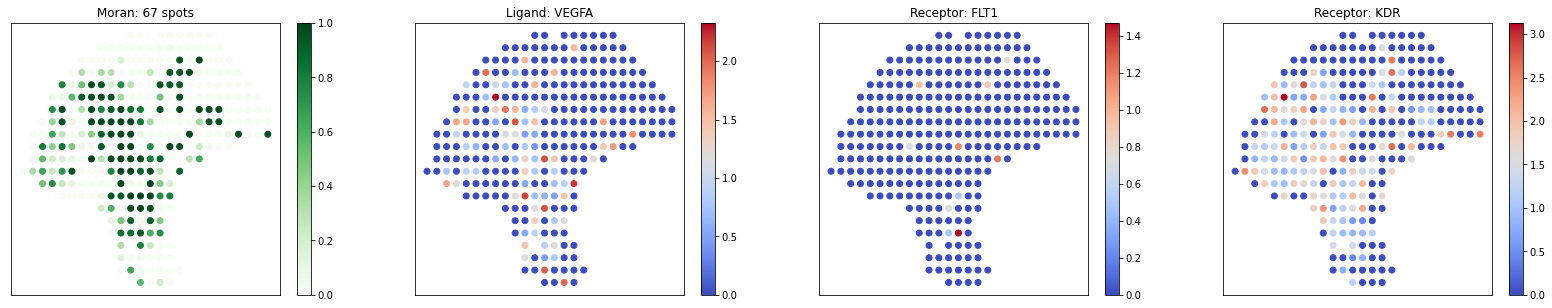

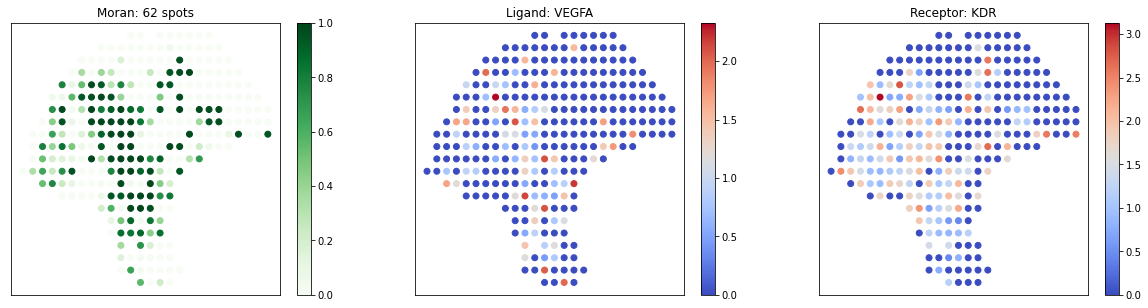

In [25]:
# visualize pattern 2 pairs
pl.plot_pairs(my_sample, dic['Pattern_0'])

Interestingly, CD23 from pattern 2 is enriched in B cell signatured spots. This is consistent with [scRNA-seq](10.1126/science.aad0501) results from Tirosh. See details in our manuscript.

<AxesSubplot:>

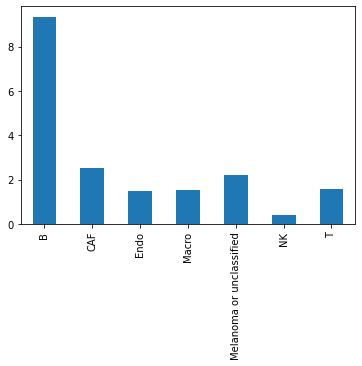

In [26]:
adata.obs[my_sample.selected_spots.loc['FCER2A_CR2'].values].sum(0).plot.bar()

In [55]:
# sel_celltype = pd.DataFrame(((np.expand_dims(my_sample.selected_spots.values,1)*adata.obs.values.T)).sum(2), 
#              index=my_sample.local_z_p.index, columns=adata.obs.columns)

# merge_res = my_sample.global_res.merge(sel_celltype, left_index=True, right_index=True)

# merge_res.to_csv('mel_summary.csv')

## Consistency between permutation and z-score approaches

As an alternative to permutation method, we derived the first and second moments of the null distribution to analytically obtain a z-score and its according p-values, which are highly consistent with the permutation method.

/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Global p-value correlation (Permutation vs. z-score)')

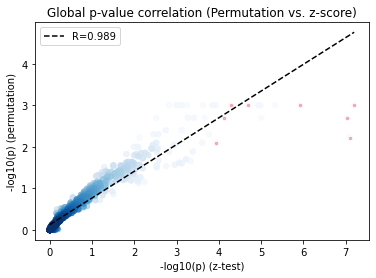

In [27]:
x = -np.log10(my_sample.global_res.z_pval.values)
y = -np.log10(my_sample.global_res.perm_pval)
x = x[~np.isinf(y)]  # x = np.where(x>3, 3, x)
y = y[~np.isinf(y)]  # y = np.where(np.isinf(y), 3, y)
pl.corr_plot(x, y, method='spearman')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Global p-value correlation (Permutation vs. z-score)')

Text(0.5, 1.0, 'Correlation of number of selected local spots (Permutation vs. z-score)')

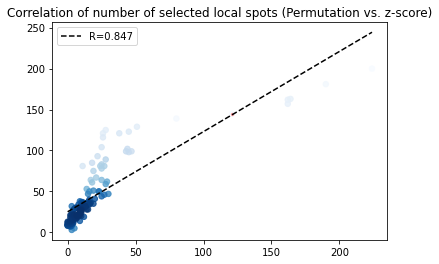

In [28]:
x=(my_sample.local_z_p<0.1).sum(1).values
y=(my_sample.local_perm_p<0.1).sum(1).values
pl.corr_plot(x, y, method='pearson')
plt.title('Correlation of number of selected local spots (Permutation vs. z-score)')